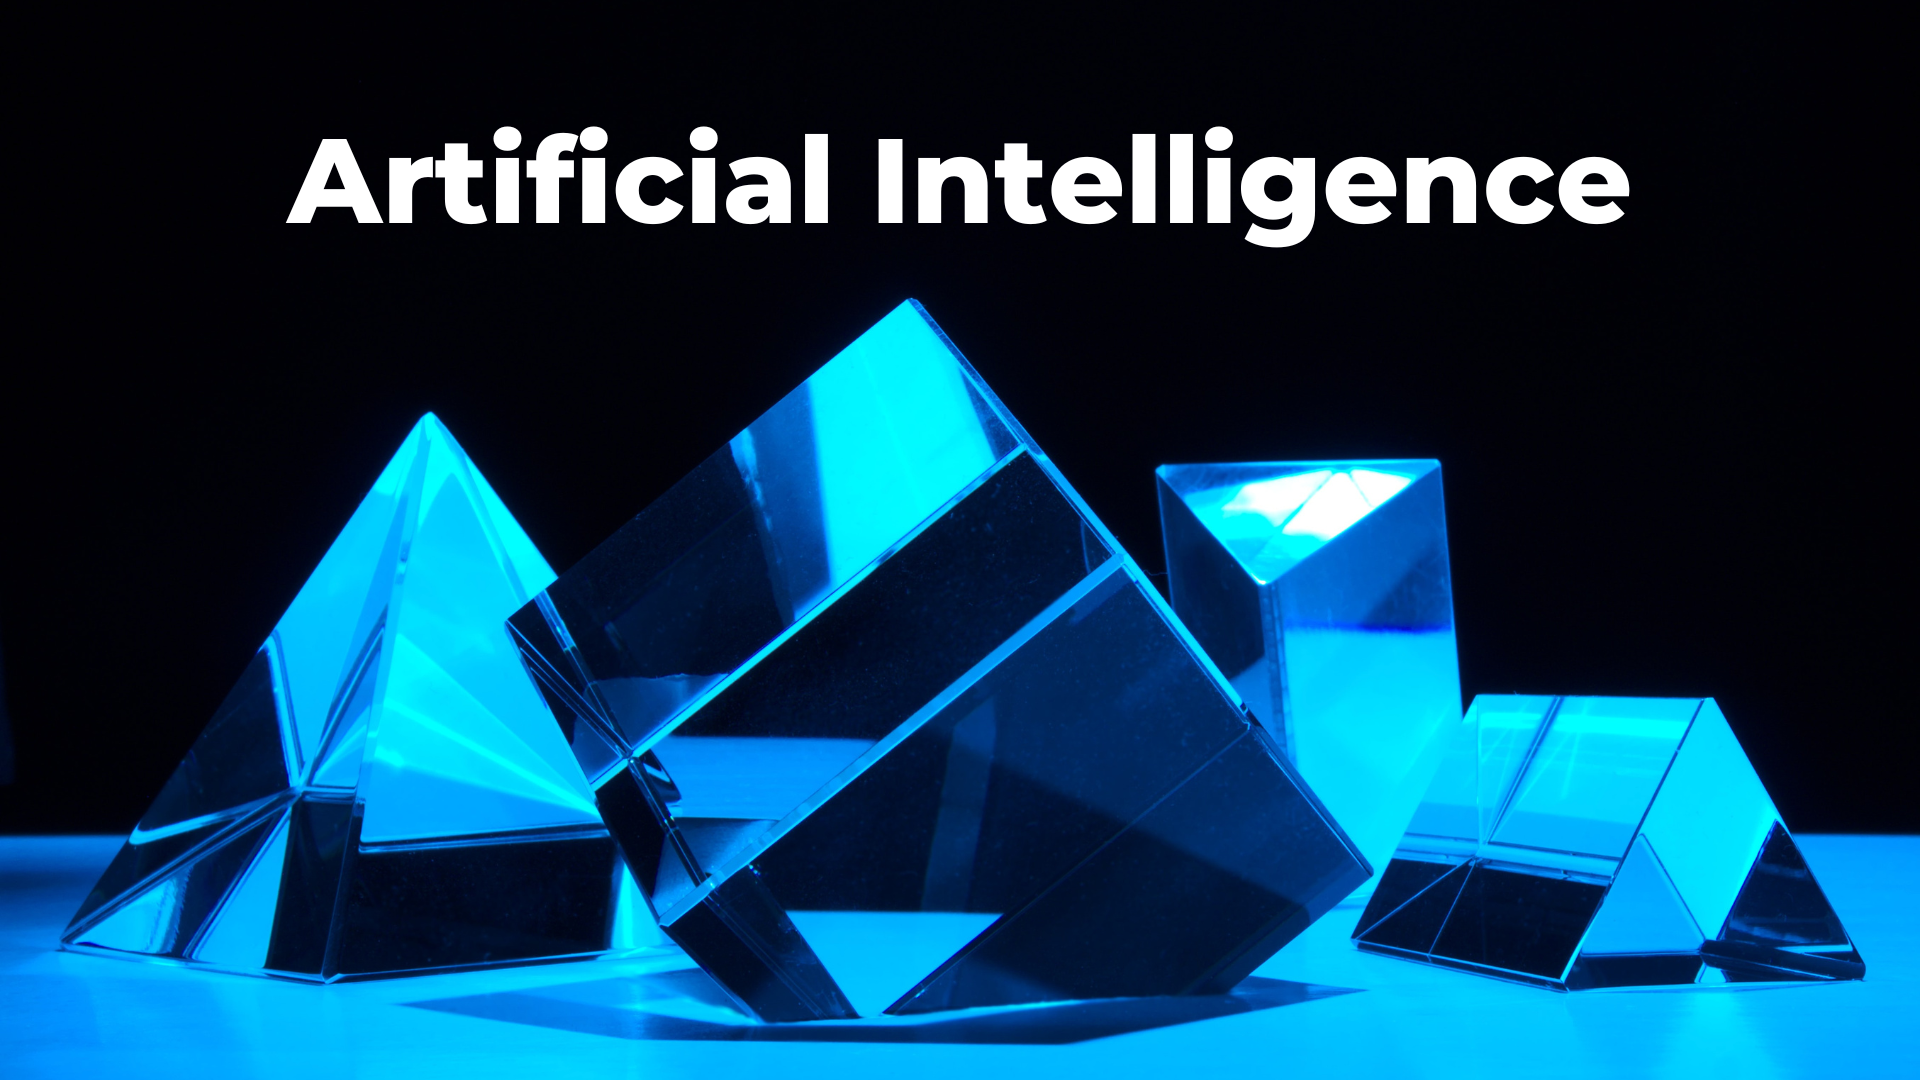

## **What is Artificial Intelligence**

**Difference between AI, Machine Learning and Deep Learning**


[Watch Video](https://youtu.be/14sawjev1sc)

# **Applications of Artificial Intelligence (Machine Learning - Deep Learning**



[Watch Video](https://youtu.be/dxpBcqSWbuk)

## **What you will Learn:**

**1. How to use Google Colab for Machine Learning**

**2. How to Download Data (Images) from the internet**

**3. How to Build an Image Recognition System (Machine Learning - DeepLearning)**

**4. How Deploy an Image Recognition System using Binder** 


## **What you won't Learn:**

**- The underlying operation of each line/blocks of code - That is beyond the scope of this lesson**

# **The Machine Learning Workflow**


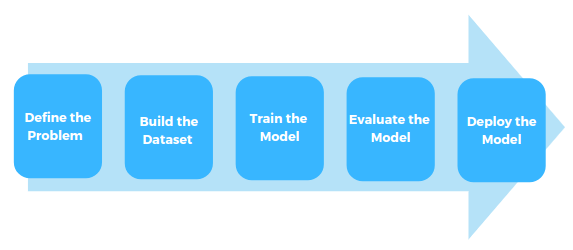

# **Getting Started**

### **Setup your google colab**

[Google colab](https://colab.research.google.com/)

### **Github**

[Github Link](https://github.com/abdulmalikadeyemo/SB4Kids_AI/tree/main)

## **Step 1: Define Problem Statement**

**Build a facial recognition system using Artificial Intelligence (Deep Learning)**

""" """

##  **STEP 2: Build the Dataset**

**Download the require library**

In [1]:
!pip install -Uqq fastai

**Import the libraries and other dependencies(libraries needed)**

In [23]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [24]:
#These are needed for dowloading the images
from io import StringIO, BytesIO
from urllib.error import URLError,HTTPError

In [25]:
import os

**Connect to your google drive: This will give us the ability to save downloaded images**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Create the function that allows you to search for images of DuckDuckGo**

In [27]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

**Create a list of the images you want to download and the path (location) you want to save it**

In [30]:
image_types = ['Kashifu Inuwa','Isa Pantami']
path = Path('/content/drive/MyDrive/Colab Notebooks/NCAIR/SB4Kids/images')

**The next line of code will make sure the path has alreadey been created and create it otherwise**

In [38]:
if not path.exists():
    path.mkdir()

**Search for the images (based on the list you created earlier), download them and save them in the location(path) you created earlier**

In [39]:
for i in image_types:
    dest = (path/i)
    dest.mkdir(exist_ok=True)
    result_urls = search_images_ddg(f'{i} image')
    download_images(dest, urls = result_urls)

**Check the number of images download and their file path**

In [ ]:
downloaded_files = get_image_files(path)
downloaded_files

**Check the number of images you have for each category**

In [ ]:
len(os.listdir('/content/drive/MyDrive/Colab Notebooks/NCAIR/SB4Kids/images/Kashifu Inuwa'))

In [ ]:
len(os.listdir('/content/drive/MyDrive/Colab Notebooks/NCAIR/SB4Kids/images/Isa Pantami'))

**Check if any image fails to open**

In [9]:
failed = verify_images(downloaded_files)
failed

**Remove failed images, if any**

In [48]:
failed.map(Path.unlink);

**Convert all the images (dataset) into something(dataloaders) that your model(AI system) can learn from**

- One of the things the next block of code does is to split our dataset into training and validation set on a 80-20 scale

In [42]:
images = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_items = get_image_files,
        splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
        get_y = parent_label,
        item_tfms = RandomResizedCrop(224, min_scale = 0.5),
        batch_tfms = [*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)]
        )

dls = images.dataloaders(path)

## **Step 3: Train the Model**

**Create a model**

In [ ]:
model = vision_learner(dls, resnet18, metrics = [accuracy])

**Train the model**

In [ ]:
model.fine_tune(9)

## **Step 4: Evaluate the model**

**Check the learning curve**

In [ ]:
model.recorder.plot_loss()

**Check how well the model is performing by printing the confusion matrix**

In [ ]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

**Steps to improve your model's performance**

1. Clean your dataset
2. Get more data
3. Train the model for more epochs (iteration)

In [22]:
# interp.plot_top_losses(4, nrows = 2)

**Clean the Dataset**

In [82]:
#Create a cleaner
cleaner = ImageClassifierCleaner(model)
cleaner

In [86]:
#Delete all the dataset that have been marked as "delete"
try:
  for idx in cleaner.delete(): cleaner.fns[idx].unlink()
except FileNotFoundError:
  pass


#### **Test the Model, by uploading new images**

**Create buttons that will allow you to upload an image and print the result**

In [47]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description = 'Who is this?')

**Put them all together**

In [48]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(250,250))
    pred, pred_idx, prob = model.predict(img)
    percent_prob = (prob[pred_idx]) * 100
    lbl_pred.value = f'The probability the picture you upload is {pred} is {percent_prob:.04f}%'
    
btn_run.on_click(on_click_classify)

**Show them**

In [ ]:
VBox([widgets.Label('Upload a Picture'), 
        btn_upload, btn_run, out_pl, lbl_pred])

## **Step 5: Deploy the model**

**Save the model**

In [50]:
model.export('sb4kids_classifier.pkl')